# Домашнее задание

ML разработчикам необходимо не только уметь обучать нейронные сети и генерировать новые идеи, но еще и уметь в страивать наработки в pipeline. В этом домашнем задании нам предстоит сделать из frustum детектора production ready (ну почти) решение, которое может работать на сырых данных.

К сожалению, frustum-pointnet работает независимо для каждой 2D детекции. В этом домашнем задании вам предстоит написать обертку над frustum-pointnet, которая будет работать над целыми облаками. Вам также нужно будет воспользоваться 2D детектором, чтобы находить коробки на изображении.

Во второй части задания вам нужно будет написать оценку качества работы вашего алгоритма, которая становится чуть сложнее, когда на сцене могут находится много объектов.

## Часть 1

Ниже написан класс, который вам нужно реализовать. Чтобы воспользоваться предобученной сетью, позаимствуйте код из
https://github.com/charlesq34/frustum-pointnets/blob/master/train/test.py

Предобученные модели лежат здесь: https://shapenet.cs.stanford.edu/media/frustum_pointnets_snapshots.zip

В частности, вам нужно модифицировать функцию `get_session_and_ops` - функция должна уметь работать без глобальных флагов. После этого посмотрите, как эта функция используется.
Выход сети преобразуется в понятный формат в функции `write_detection_results`.

In [12]:
# ! pip install "tensorflow==1.14"

In [1]:
from collections import namedtuple

Detection = namedtuple('Detection', ['xyz', 'angle', 'lwh', 'confidence'])
Scene = namedtuple('Scene', ['detections'])

class PipelineDetector(object):
    def __init__(self, frustum_pointnet, frustum_batch_size, ssd_detector, ssd_threshold):
        pass
    
    def predict(self, xyz, image, car_to_cam, intrinsics):
        # TODO: run 2D detector on the image
        # TODO: extract bounding boxes with vehicle classes and filter them by ssd_threshold
        # TODO: process lidar point cloud and construct frustum examples
        # TODO: run frustum inference (use batch to accelerate inference per frame)
        # TODO: construct Scene namedtuple and return it
        pass
    

### 2D детектор

В файле ssd.py есть детектор (файл называется ssd, но на самом деле там faster-rcnn), обученный на kitti. У него можно позвать predict на одном изображении. Коробки возвращаются в нормализованных координатах картинки. Класс 1 соответствует машинам, 2 - пешеходам.

In [4]:
from ssd import SSD
import pickle

In [6]:
detector = SSD('tmp')

In [8]:
with open('projection_example.npy') as f:
    data_example = pickle.load(file=f)

In [9]:
image = data_example['image']

In [10]:
detector.predict(image)

{'detection_boxes': array([[0.56678456, 0.42429185, 0.7745029 , 0.46590117],
        [0.55427235, 0.3236863 , 0.77801454, 0.3629127 ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.      

## Часть 2

Для оценки качества работы 3D детекторов обычно используется average precision. Как измерить precision и recall детектора?

У каждой коробки детектора есть confidence. После того, как мы зафиксировали порог, у нас остается часть детекций.
Давайте теперь посмотрим на сцену сверху: bird's eye view. Забудем про координату z.

Далее мы можем посчитать IoU между всеми коробками ground truth и нашими детекциями.Давайте решим, что если IoU больше 0.7, то мы будем считать, что мы увидели gt коробку - относим эту детекцию к TP. Если gt не нашла пару - False Negative. Если детекция не нашла пару - False Positive.

Ваша задача написать код подсчета метрики average precision построенного детектора.

# Kitti Dataset
[Kitti dev-kit](https://s3.eu-central-1.amazonaws.com/avg-kitti/devkit_object.zip) : 
там можно найти описание данных и как преобразовывать данные между системами координат.

Homework KITTI dataset :https://www.icloud.com/iclouddrive/0bxlXWgCRTVvsWXmd-kcEqKqA#kitti_hw_dataset

In [19]:
import numpy as np
from matplotlib import pyplot as plt 

In [36]:
xyzi = np.fromfile('../kitti_dataset/training/velodyne/000100.bin', dtype=np.float32).reshape(-1, 4)

In [37]:
xyzi

array([[43.889,  0.084,  1.693,  0.   ],
       [43.201,  0.218,  1.67 ,  0.   ],
       [42.397,  0.347,  1.643,  0.   ],
       ...,
       [ 3.696, -1.398, -1.726,  0.31 ],
       [ 3.717, -1.399, -1.736,  0.35 ],
       [ 3.724, -1.389, -1.737,  0.   ]], dtype=float32)

(-50, 50)

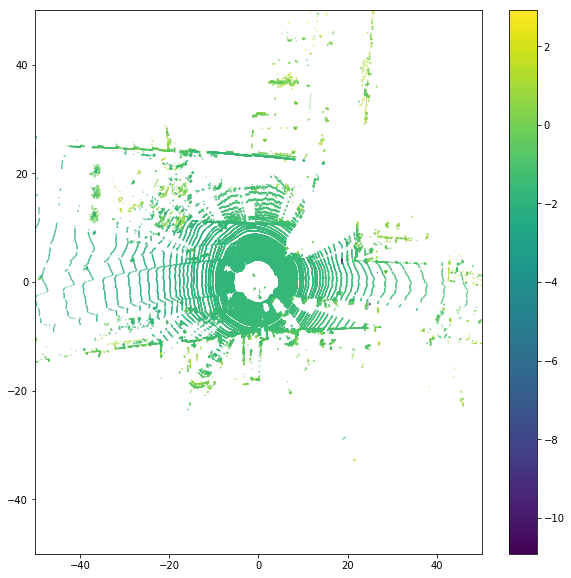

In [43]:
plt.figure(figsize=(10, 10))
plt.scatter(xyzi[:, 0], xyzi[:, 1], c=xyzi[:, 2],  s=0.1)
plt.colorbar()
plt.xlim(-50, 50)
plt.ylim(-50, 50)

In [39]:
import Image

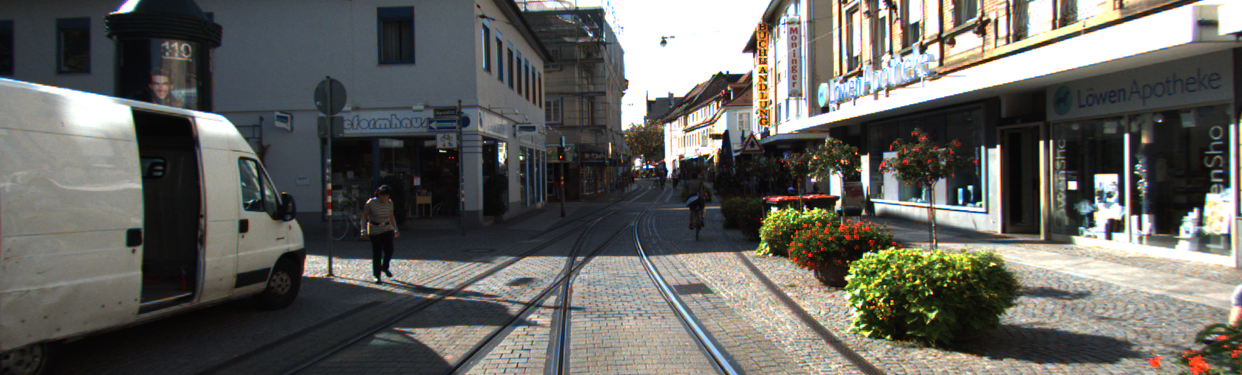

In [40]:
Image.open('../kitti_dataset/training/image_2/000100.png')

In [41]:
with open('../kitti_dataset/training/calib/000100.txt') as f:
    print f.read()

P0: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 0.000000000000e+00 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00
P1: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 -3.875744000000e+02 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00
P2: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 4.485728000000e+01 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 2.163791000000e-01 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 2.745884000000e-03
P3: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 -3.395242000000e+02 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 2.199936000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 2.729905000000e-03
R0_rect: 9.999239000000e-01 9.837760000000e-03 -7.445048000000e-03 -9.

In [45]:
with open('../kitti_dataset/training/label_2/000100.txt') as f:
    print f.read()

Van 0.63 0 -0.90 0.00 58.65 320.90 374.00 2.46 2.03 5.35 -5.18 1.69 7.24 -1.51
Cyclist 0.00 0 -1.58 684.31 165.66 710.23 242.31 1.82 0.59 1.89 2.13 1.66 18.06 -1.47
Pedestrian 0.00 0 0.84 359.32 182.26 400.32 285.85 1.57 0.52 0.62 -3.63 1.72 11.35 0.54
Car 0.00 2 -2.46 19.88 179.87 206.64 238.00 1.44 1.62 3.91 -13.04 1.64 18.98 -3.05
DontCare -1 -1 -10 650.19 158.35 666.90 192.77 -1 -1 -1 -1000 -1000 -1000 -10

